In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import random
import os
import numpy as np

from torch.autograd import Variable
from utils import accuracy_score

from transformers import RobertaTokenizer, RobertaModel

In [2]:
def seed_torch(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(1)

In [3]:
# EXAMPLE
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
text_batch = ["I love Pixar.", "I don't care for Pixar."]
encoding = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']
labels = torch.tensor([1,0]).unsqueeze(0)
outputs = model(input_ids, attention_mask=attention_mask)
print(outputs.last_hidden_state.shape) #number of data, sequence length, hidden state size
print(outputs.last_hidden_state[:,0,:].shape) # connect this to FC layer (768,2) to do binary classfication)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([2, 9, 768])
torch.Size([2, 768])


In [4]:
class TextClassifier(nn.Module):
    def __init__(self, args, model_name='roberta-base', num_groups=3, batch_size=32, max_length=128):
        super(TextClassifier, self).__init__()
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.model = RobertaModel.from_pretrained(model_name)
        self.batch_size = batch_size
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fc = nn.Linear(self.model.config.hidden_size, 3)  # FC layer
        self.criterion = torch.nn.CrossEntropyLoss()#ignore_index=0
        self.softmax = torch.nn.Softmax(dim=1)
        self.optimizer = torch.optim.Adam(self.model.parameters(),  lr= args.lr ,  betas=(0, 0.9)  )
        self.scheduler =torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=args.gamma)
        self.epoch = args.epochs

    def forward(self,x,x_att):
        output = self.model(x,attention_mask=x_att)
        hidden_states = output.last_hidden_state[:,0,:] #[cls] tokens
        logits = self.fc(hidden_states)
        logits = self.softmax(logits) #not sure whether we need this line to compute loss
        return logits
    
    def loss(self,logits,labels):
        loss = self.criterion(logits, labels)
        return loss

    def train(self,train_dataloader,valid_dataloader,device):
        model.train()
        for epoch in range(self.epochs):
            train_loss = 0.0
            for step,batch in enumerate(train_dataloader):
                input_ids = Variable(batch[0], requires_grad=False).to(device, non_blocking=False)
                input_attn = Variable(batch[1], requires_grad=False).to(device, non_blocking=False)
                labels = Variable(batch[2], requires_grad=False).to(device, non_blocking=False)    

                self.optimizer.zero_grad()
                logits = self.forward(input_ids,input_attn)
                loss = self.loss(logits,labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")

            # Validation
            self.model.eval()
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for step,batch in enumerate(valid_dataloader):
                    input_ids = Variable(batch[0], requires_grad=False).to(device, non_blocking=False)
                    input_attn = Variable(batch[1], requires_grad=False).to(device, non_blocking=False)
                    labels = Variable(batch[2], requires_grad=False).to(device, non_blocking=False)   
                    
                    logits = self.forward(input_ids,input_attn)
                    loss = self.loss(logits,labels)

                    predict = torch.argmax(logits,dim=1)
                    accuracy = accuracy_score(labels, predict)


            print(f"Validation Loss: {loss:.4f}")
            print(f"Validation Accuracy: {accuracy:.4f}")
            self.model.train()

   

# classifier = RoBERTaTextClassifier("roberta-base", num_labels=3)
# train_texts, train_labels, validation_texts, validation_labels = ... multiNLP
# classifier.train(train_texts, train_labels, validation_texts, validation_labels)
# test_texts = ...
# predictions = classifier.predict(test_texts)


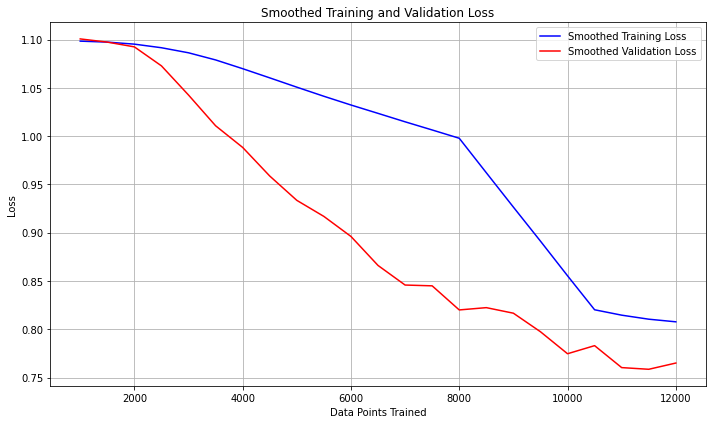

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    """Compute the moving average of a list or array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# Load the loss data from the npy files
train_loss = np.load('logs/trainloss_10_57_19_10_2023.npy')
validation_loss = np.load('logs/validationloss_10_57_19_10_2023.npy')

# Smooth the loss data using a moving average
window_size = 5  # Choose a window size that gives the desired smoothness
smooth_train_loss = moving_average(train_loss, window_size)
smooth_validation_loss = moving_average(validation_loss, window_size)

# Create the x-axis values
x_values = np.arange(len(smooth_train_loss)) * 500 + (window_size // 2) * 500  # adjust for moving average shift

# Plot the smoothed losses
plt.figure(figsize=(10, 6))
plt.plot(x_values, smooth_train_loss, label='Training Loss', color='blue')
plt.plot(x_values, smooth_validation_loss[1:], label='Validation Loss', color='red')
plt.xlabel('Data Points Trained')
plt.ylabel('Loss')
plt.title('Smoothed Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
